# Rough Heston Model

I built a full rough Heston option-pricing pipeline in Python that starts from a clean n-step discrete Heston baseline and then replaces the Markovian variance process with a fractional Volterra kernel. The core of the project is a fast Monte Carlo engine using the Volterra-Euler scheme with precomputed memory weights, antithetic variates, and vectorized path generation, which lets me simulate large path bundles for realistic maturities and fine time grids.

On top of the path simulator I implemented payoffs (calls and puts), implied-volatility inversion, and plotting utilities to visualize price smiles, term structures, and IV surfaces. I benchmark the rough model against the classical Heston under identical path and step controls, comparing prices, IV smiles/surfaces, and Monte Carlo convergence behavior. The repository is organized as a small research playground with configurable simulators (number of paths, steps, Hurst parameter, correlation, seeds), reproducible notebooks that regenerate all figures, and clean plots that are ready to drop into a report, thesis, or presentation.

---

# n-step discrete Heston model

As a baseline, I first implement the classical Heston model on a general time grid using an n-step Euler scheme for the variance and a log-Euler step for the price.

Let $0=t_0<t_1<\cdots<t_n=T$. Define $\Delta t_i=t_i-t_{i-1}$.
For $i=1,\dots,n$,
$$
\boxed{
v_{t_i}
= \max(v_{t_{i-1}},0)
+ \kappa\big(\theta - \max(v_{t_{i-1}},0)\big)\,\Delta t_i
+ \xi \sqrt{\,\max(v_{t_{i-1}},0)\,\Delta t_i\,}\;N_i^{v}
}
$$
$$
\boxed{
S_{t_i}
= S_{t_{i-1}}\,
\exp\!\Big((\mu+r-\tfrac12 \max(v_{t_{i-1}},0))\,\Delta t_i
+ \sqrt{\,\max(v_{t_{i-1}},0)\,\Delta t_i\,}\;N_i^{S}\Big)
}
$$
with $(N_i^{v},N_i^{S})$ standard normals, $\mathrm{Corr}(N_i^{v},N_i^{S})=\rho$, independent across times.

**Parameters**
- $S_0$: initial stock price, $S_{t_i}$: stock at time $t_i$
- $v_0$: initial variance, $v_{t_i}$: variance at time $t_i$
- $\mu$: excess drift of log-returns, $r$: risk-free rate
- $\kappa$: mean-reversion rate, $\theta$: long-run variance level
- $\xi$: volatility of volatility, $\rho$: correlation


---

# Rough Heston (Volterra–Euler)

The rough Heston implementation keeps the same price update as in the classical case, but the variance process is driven by a Volterra integral with a fractional kernel that encodes long memory. Numerically, this becomes a weighted sum over all past increments with precomputed memory coefficients.

Use a uniform grid $\Delta t = T/n$. Set
$$
\beta = H+\tfrac12,\qquad
\alpha_m = m^{\beta} - (m-1)^{\beta}\ (m\ge1),\qquad
c_H=\frac{1}{\Gamma(H+\tfrac12)} .
$$
For $i=1,\dots,n$,
$$
\boxed{
\begin{aligned}
v_{t_i}
&= v_{0}
+ c_H\,\Delta t^{\beta}\sum_{j=0}^{i-1} \alpha_{i-j}\,\kappa\big(\theta - v_{t_j}^{+}\big)
+ \xi\,c_H\,\Delta t^{H}\sum_{j=0}^{i-1} \alpha_{i-j}\,\sqrt{\,v_{t_j}^{+}\,}\;N_{j+1}^{v}
\end{aligned}}
$$
$$
\boxed{
S_{t_i}
= S_{t_{i-1}}\,
\exp\!\Big((\mu+r-\tfrac12 \max(v_{t_{i-1}},0))\,\Delta t
+ \sqrt{\,\max(v_{t_{i-1}},0)\,\Delta t\,}\;N_i^{S}\Big)
}
$$
with the same $(N_i^{v},N_i^{S})$ and $\mathrm{Corr}(N_i^{v},N_i^{S})=\rho$.

- $H$: Hurst parameter controlling roughness and memory. Smaller $H$ gives rougher, more jagged volatility and stronger short-range dependence. $H=\tfrac12$ recovers classical Heston. In practice $0<H<1$ with the rough regime $H<\tfrac12$.
- $\beta = H+\tfrac12$: exponent used in the memory weights and $\Delta t^\beta$ scaling.
- $\alpha_m = m^{\beta}-(m-1)^{\beta}$: discrete memory weights for the $m$-step lag. For large $m$, $\alpha_m \approx \beta\, m^{H-\tfrac12}$. When $H<\tfrac12$ the weights decay with lag.
- $c_H = 1/\Gamma(H+\tfrac12)$: kernel normalization constant from the fractional Volterra kernel.

**Notes**
- Classical Heston uses only the most recent value $\max(v_{t_{i-1}},0)$.
- Rough Heston blends all past steps via the memory weights $\alpha_{i-j}$, controlled by the Hurst parameter $H$.
- Sanity check: if $H=\tfrac12$ then $\alpha_m=1$ and the rough recursion collapses to the classical Euler scheme.
- In code, the $\alpha_m$ and $c_H$ factors are precomputed once per grid so that path generation remains fast enough for large Monte Carlo experiments.


# Plot classical Heston paths

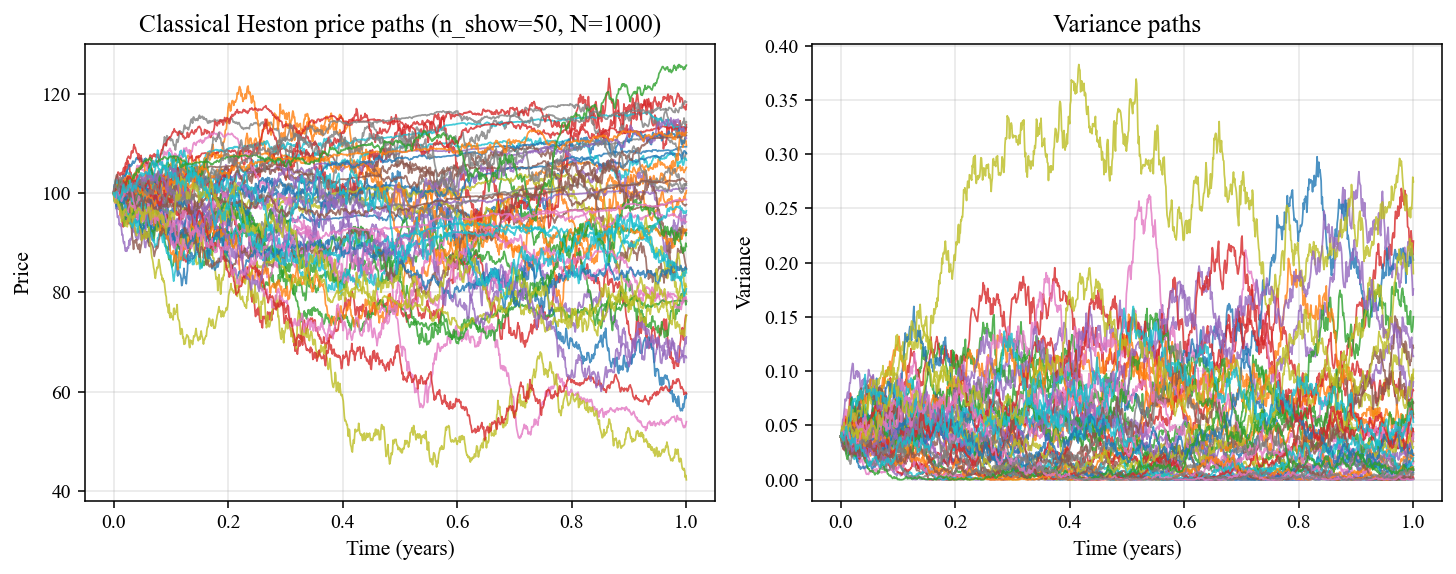

In [31]:
# Plot classical Heston paths using Erdos.py discretization

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update(mpl.rcParamsDefault)   # reset to defaults
plt.style.use("default")                  # make sure we use the default style
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"


# Styling (match other plotting utilities in the project)
rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 140,
})


def simulate_heston_paths_with_variance(
    S0: float,
    v0: float,
    r: float,
    t: float,
    rho: float,
    kappa: float,
    theta: float,
    xi: float,
    mu: float,
    n_sims: int,
    n_steps: int,
    *,
    seed: int | None = None,
):
    """
    Simulate classical Heston price and variance paths via the Euler scheme
    implemented in Erdos.heston_paths (replicated here to also return variance).

    Returns
    - times: (n_steps+1,) grid from 0..t
    - S: (n_sims, n_steps+1) price paths
    - V: (n_sims, n_steps+1) variance paths
    """
    if seed is not None:
        np.random.seed(int(seed))

    dt = t / n_steps
    times = np.linspace(0.0, t, n_steps + 1)

    # Correlated normals
    noise1 = np.random.normal(size=(n_sims, n_steps))
    Y = np.random.normal(size=(n_sims, n_steps))
    noise2 = rho * noise1 + np.sqrt(max(1.0 - rho * rho, 0.0)) * Y

    # Variance (CIR) discretization (Euler, floored at 0)
    V_inner = np.zeros((n_sims, n_steps), dtype=float)
    V_inner[:, 0] = v0
    for i in range(1, n_steps):
        prev = V_inner[:, i - 1]
        V_inner[:, i] = prev + kappa * (theta - prev) * dt + xi * np.sqrt(np.maximum(prev, 0.0) * dt) * noise1[:, i - 1]
        V_inner[:, i] = np.maximum(V_inner[:, i], 0.0)

    # Log-returns and prices
    log_ret = (mu + r - 0.5 * V_inner) * dt + np.sqrt(np.maximum(V_inner, 0.0) * dt) * noise2
    expo = np.cumsum(log_ret, axis=1)
    S_inner = S0 * np.exp(expo)

    # Align to include t=0
    S = np.insert(S_inner, 0, S0, axis=1)
    V = np.zeros((n_sims, n_steps + 1), dtype=float)
    V[:, 0] = v0
    V[:, 1:] = V_inner

    return times, S, V


def plot_heston_paths(
    S0=100.0, v0=0.04, r=0.01,
    rho=-0.7, kappa=1.5, theta=0.04, xi=0.5, mu=0.0,
    t=1.0, n_steps=1000, n_sims=1000, n_show=50,
    *, seed=123, show_variance=True,
):
    """
    Plot classical Heston price (and variance) paths using Erdos discretization.

    Parameters match Erdos.heston_paths, with an added seed and show_variance.
    Returns (times, S, V).
    """
    n_show = int(min(max(1, n_show), n_sims))
    times, S, V = simulate_heston_paths_with_variance(
        S0=S0, v0=v0, r=r, t=t, rho=rho, kappa=kappa, theta=theta, xi=xi,
        mu=mu, n_sims=int(n_sims), n_steps=int(n_steps), seed=seed,
    )

    if show_variance:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10.5, 4.2))
    else:
        fig, ax1 = plt.subplots(figsize=(6.8, 4.2))

    # Price paths
    for i in range(n_show):
        ax1.plot(times, S[i, :], lw=0.9, alpha=0.8)
    ax1.set_title(f"Classical Heston price paths (n_show={n_show}, N={n_steps})")
    ax1.set_xlabel("Time (years)")
    ax1.set_ylabel("Price")
    ax1.grid(True, alpha=0.3)

    # Variance paths
    if show_variance:
        for i in range(n_show):
            ax2.plot(times, np.maximum(V[i, :], 0.0), lw=0.9, alpha=0.8)
        ax2.set_title("Variance paths")
        ax2.set_xlabel("Time (years)")
        ax2.set_ylabel("Variance")
        ax2.grid(True, alpha=0.3)
        fig.tight_layout()
    else:
        fig.tight_layout()

    plt.show()
    return times, S, V


# Example parameters
S0, v0 = 100.0, 0.04
r = 0.01
rho = -0.7
kappa, theta, xi = 1.5, 0.04, 0.5
mu = 0.0
t, n_steps = 1.0, 1000
n_sims, n_show = 1000, 50
seed = 123



plot_heston_paths(
    S0=S0, v0=v0, r=r, rho=rho,
    kappa=kappa, theta=theta, xi=xi, mu=mu,
    t=t, n_steps=n_steps, n_sims=n_sims, n_show=n_show,
    seed=seed, show_variance=True,
);



# Plot Rough Heston paths using the log-Euler simulator

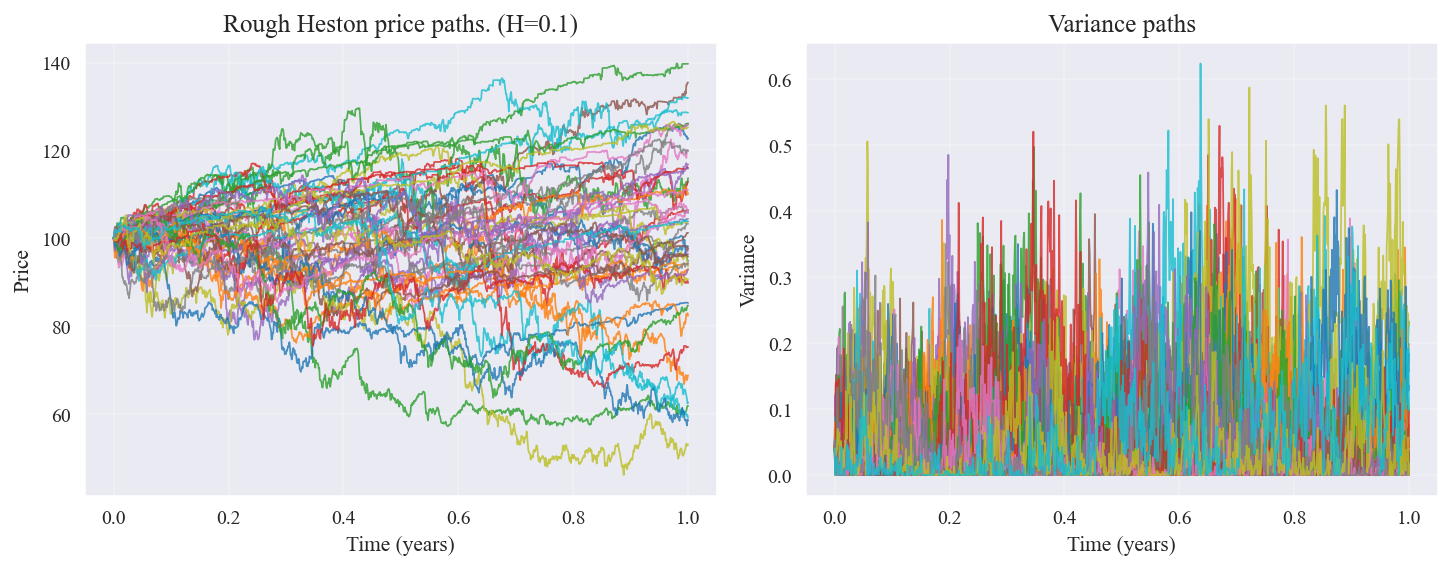

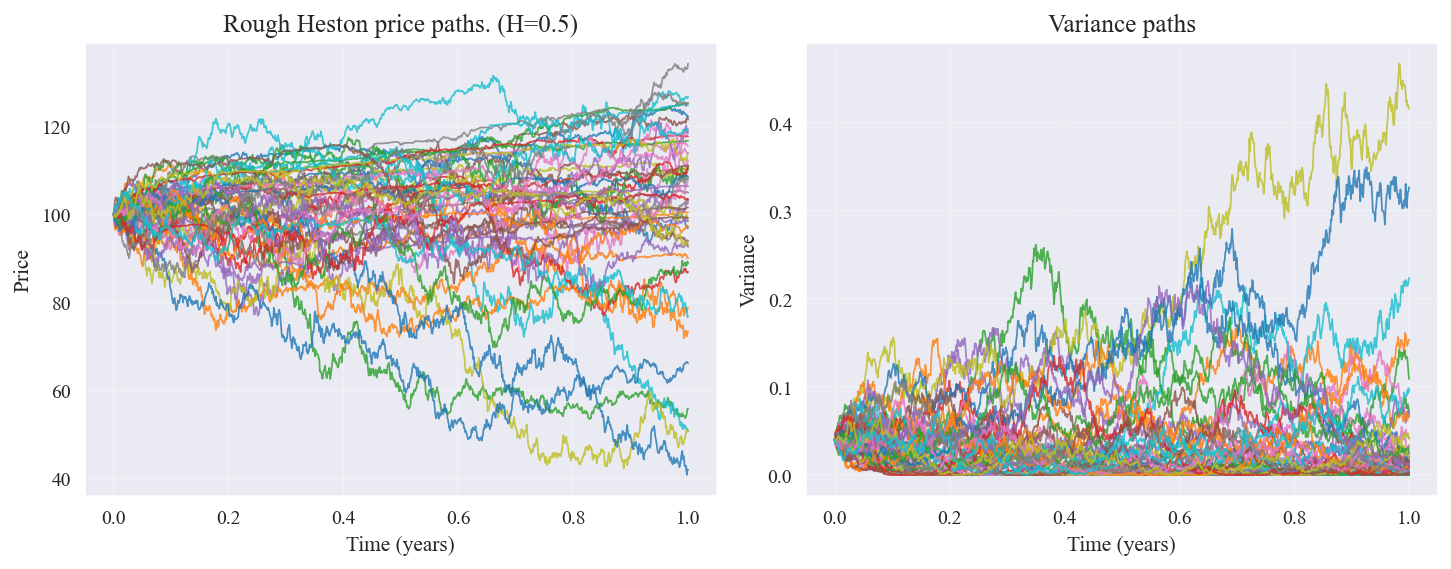

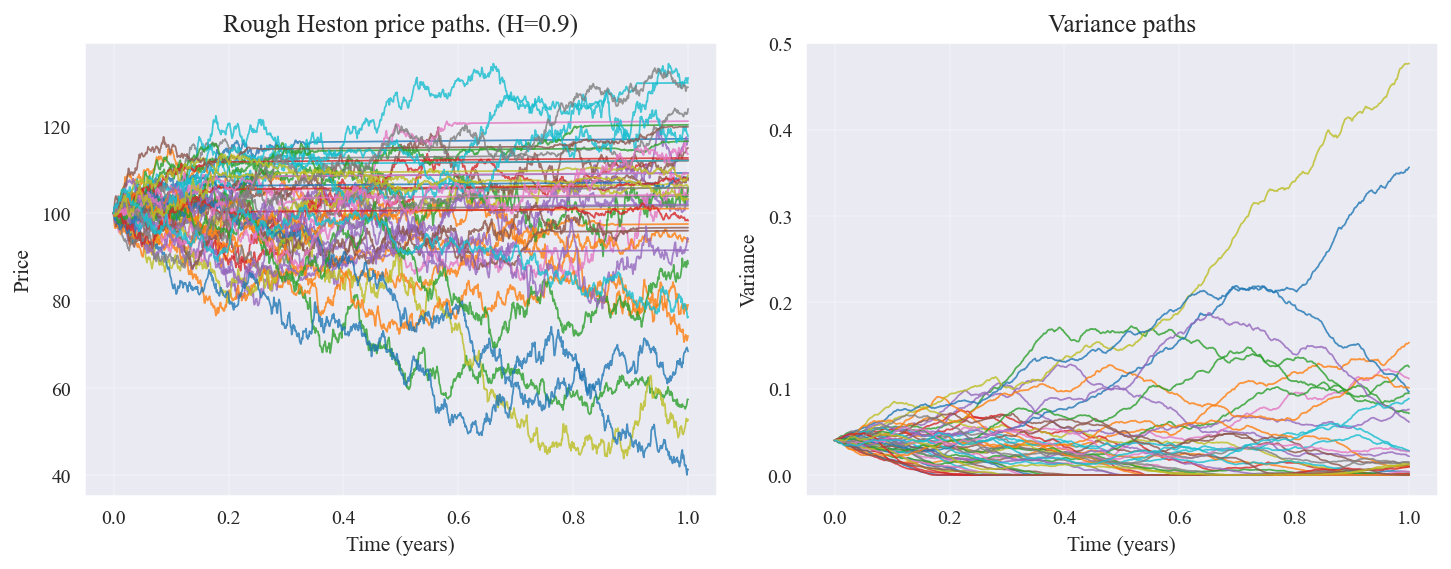

In [27]:


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from rough import rough_heston_paths


# Styling
rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 140,
})


def plot_rough_heston_paths(
    S0=100.0, v0=0.04, r=0.01, q=0.0,
    rho=-0.7, kappa=1.5, theta=0.04, eta=0.5, H=0.10,
    T=1.0, N=1000, n_paths=1000, n_show=50,
    *, seed=123, use_numba=True, batch_size=4096,
    show_variance=True,
):
    """
    Simulate and plot Rough Heston price (and variance) paths.

    Parameters
    ----------
    S0, v0, r, q, rho, kappa, theta, eta, H : float
        Model parameters (see rough_heston_paths in rough.py).
    T : float
        Maturity in years.
    N : int
        Number of time steps.
    n_paths : int
        Total number of simulated paths.
    n_show : int
        Number of paths to draw on the figure (first n_show paths).
    seed : int
        RNG seed for reproducibility.
    use_numba : bool
        Use Numba implementation if available.
    batch_size : int
        Per-batch path count in the simulator.
    show_variance : bool
        If True, also plot variance paths.

    Returns
    -------
    (t, S, V)
        The time grid and arrays returned by rough_heston_paths.
    """
    n_show = int(min(max(1, n_show), n_paths))
    t, S, V = rough_heston_paths(
        S0=S0, v0=v0, T=T, N=int(N), n_paths=int(n_paths), H=H,
        kappa=kappa, theta=theta, eta=eta, rho=rho,
        r=r, q=q, seed=seed, batch_size=batch_size, use_numba=use_numba,
    )

    if show_variance:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10.5, 4.2))
    else:
        fig, ax1 = plt.subplots(figsize=(6.8, 4.2))

    # Price paths
    for i in range(n_show):
        ax1.plot(t, S[i, :], lw=0.9, alpha=0.8)
    ax1.set_title(f"Rough Heston price paths. (H={H})")
    ax1.set_xlabel("Time (years)")
    ax1.set_ylabel("Price")
    ax1.grid(True, alpha=0.3)

    # Variance paths (optional)
    if show_variance:
        for i in range(n_show):
            ax2.plot(t, np.maximum(V[i, :], 0.0), lw=0.9, alpha=0.8)
        ax2.set_title("Variance paths")
        ax2.set_xlabel("Time (years)")
        ax2.set_ylabel("Variance")
        ax2.grid(True, alpha=0.3)
        fig.tight_layout()
    else:
        fig.tight_layout()

    plt.show()
    return t, S, V



# Example parameters
S0, v0 = 100.0, 0.04
r, q = 0.01, 0.0
rho = -0.7
kappa, theta, eta, H = 1.5, 0.04, 0.5, 0.10
T, N = 1.0, 1000
n_paths, n_show = 1000, 50
seed = 123

plot_rough_heston_paths(
    S0=S0, v0=v0, r=r, q=q, rho=rho,
    kappa=kappa, theta=theta, eta=eta, H=H,
    T=T, N=N, n_paths=n_paths, n_show=n_show,
    seed=seed, use_numba=True, batch_size=4096,
    show_variance=True,
);
plot_rough_heston_paths(
    S0=S0, v0=v0, r=r, q=q, rho=rho,
    kappa=kappa, theta=theta, eta=eta, H=0.5,
    T=T, N=N, n_paths=n_paths, n_show=n_show,
    seed=seed, use_numba=True, batch_size=4096,
    show_variance=True,
);

plot_rough_heston_paths(
    S0=S0, v0=v0, r=r, q=q, rho=rho,
    kappa=kappa, theta=theta, eta=eta, H=0.9,
    T=T, N=N, n_paths=n_paths, n_show=n_show,
    seed=seed, use_numba=True, batch_size=4096,
    show_variance=True,
);



In [ ]:
from rough import validate_rough_heston

# Full validation (parity, martingale, step-convergence)
res = validate_rough_heston(
S0=100, v0=0.04, r=0.01, T=1.0, q=0.0,
rho=-0.7, kappa=1.5, theta=0.04, eta=0.5, H=0.10,
K=100, n_paths=20_000, N=1000, steps_grid=(500, 1000, 1500),
seed=123, verbose=True,  use_numba=False
)
print(res) # dict with pass/fail flags and metrics



[validate_rough_heston]
  Parity residual +0.062387  SE 0.131711  PASS=True
  Martingale err  +0.062387  PASS=True
  Step grid (500, 1000, 1500) prices [7.90268, 7.921363, 7.795558]
  Step conv PASS=True  (max excess +0.000000)
{'parity_residual': 0.062386643088657046, 'parity_se': 0.13171065447293642, 'parity_pass': True, 'martingale_error': 0.062386643088672145, 'martingale_pass': True, 'steps_grid': [500, 1000, 1500], 'step_prices': [7.9026796253760345, 7.921363085295636, 7.7955580840838286], 'steps_pass': True}


In [1]:
from rough import validate_rough_heston, check_put_call_parity_rough

# Full validation (parity, martingale, step-convergence)
res = validate_rough_heston(
S0=100, v0=0.04, r=0.01, T=1.0, q=0.0,
rho=-0.7, kappa=1.5, theta=0.04, eta=0.5, H=0.10,
K=100, n_paths=20_000, N=1000, steps_grid=(500, 1000, 1500),
seed=123, verbose=True, use_numba=True
)
print(res) # dict with pass/fail flags and metrics

residual, C, P = check_put_call_parity_rough(
S0=100, v0=0.04, r=0.01, T=1.0, q=0.0,
rho=-0.7, kappa=1.5, theta=0.04, eta=0.5, H=0.10,
K=100, n_paths=20_000, N=1000, seed=123, use_numba=True
)
print(residual, C, P)

residual, C, P = check_put_call_parity_rough(
S0=100, v0=0.04, r=0.01, T=1.0, q=0.0,
rho=-0.7, kappa=1.5, theta=0.04, eta=0.5, H=0.10,
K=100, n_paths=20_000, N=1000, seed=123, use_numba=False
)
print(residual, C, P)


[validate_rough_heston]
  Parity residual +0.062387  SE 0.131711  PASS=True
  Martingale err  +0.062387  PASS=True
  Step grid (500, 1000, 1500) prices [7.90268, 7.921363, 7.795569]
  Step conv PASS=True  (max excess +0.000000)
{'parity_residual': 0.06238664311293096, 'parity_se': 0.13171065447363134, 'parity_pass': True, 'martingale_error': 0.062386643112930074, 'martingale_pass': True, 'steps_grid': [500, 1000, 1500], 'step_prices': [7.902679625375964, 7.921363085323019, 7.795569290587699], 'steps_pass': True}
0.06238664311293096 7.921363085323018 6.863959817126892
0.062386643088657046 7.921363085295634 6.8639598171237814


In [16]:
# ==============================
# IV surface via rough_heston_paths (log-Euler, rough.py)
# ==============================
import numpy as np
import math
from scipy.special import ndtr  # vectorized normal CDF
from rough import rough_heston_paths


# ---------- Black-Scholes, vectorized ----------
SQRT_2PI = math.sqrt(2.0 * math.pi)


def _bs_call_vec(F, K, df, T, sigma):
    volT = sigma * np.sqrt(T)
    inv = 1.0 / np.maximum(volT, 1e-12)
    d1 = (np.log(F / K) + 0.5 * volT * volT) * inv
    d2 = d1 - volT
    return df * (F * ndtr(d1) - K * ndtr(d2))


def _vega_vec(F, K, df, T, sigma):
    volT = sigma * np.sqrt(T)
    inv = 1.0 / np.maximum(volT, 1e-12)
    d1 = (np.log(F / K) + 0.5 * volT * volT) * inv
    return df * F * np.exp(-0.5 * d1 * d1) / SQRT_2PI * np.sqrt(T)


def implied_vol_newton_vec(target_C, S0, K, T, r, q, sigma0=None, iters=8, tol=1e-8):
    K = np.asarray(K, float)
    F = S0 * np.exp((r - q) * T)
    df = np.exp(-r * T)

    intrinsic = np.maximum(S0 * np.exp(-q * T) - K * df, 0.0)
    upper = S0 * np.exp(-q * T)
    C = np.clip(target_C, intrinsic, upper)

    if sigma0 is None:
        sigma0 = np.full_like(K, 0.2, dtype=float)
        atm = np.abs(np.log(F / K)) < 1e-4
        if np.any(atm):
            sigma0[atm] = np.clip((C[atm] / (df * F)) * math.sqrt(2.0 * math.pi) / np.sqrt(T), 1e-4, 3.0)

    sigma = np.clip(sigma0, 1e-6, 5.0)
    for _ in range(iters):
        price = _bs_call_vec(F, K, df, T, sigma)
        vega = np.maximum(_vega_vec(F, K, df, T, sigma), 1e-12)
        step = (price - C) / vega
        sigma = np.clip(sigma - step, 1e-6, 5.0)
        if np.nanmax(np.abs(step)) < tol:
            break
    return sigma


# ---------- helper to extract S_T ----------
def _terminal_prices_from_sim(sim_out):
    """Extract terminal prices S_T from rough_heston_paths output (t, S, V)."""
    t, S, V = sim_out
    return np.asarray(S)[:, -1]


# ---------- main surface builder ----------
def iv_surface_rough_heston_paths(
    S0, v0, r, q, rho, kappa, theta, eta, H,
    Ks, Ts, *,
    n_paths=7000, steps_per_year=256,
    seed=4242, use_numba=True, batch_size=8192,
):
    """
    Build an implied volatility surface from Rough Heston log-Euler paths.

    Parameters are identical in spirit to the Volterra version but use
    eta (vol-of-vol) and the rough_heston_paths interface.
    """
    Ks = np.asarray(Ks, float)
    Ts = np.asarray(Ts, float)
    iv = np.full((len(Ts), len(Ks)), np.nan)

    # reproducible per-maturity seeds
    ss = np.random.SeedSequence(seed)
    seeds = [int(s.generate_state(1)[0]) for s in ss.spawn(len(Ts))]

    for i, T in enumerate(Ts):
        N = max(2, int(np.ceil(steps_per_year * T)))

        sim_out = rough_heston_paths(
            S0=S0, v0=v0, T=float(T), N=int(N), n_paths=int(n_paths), H=H,
            kappa=kappa, theta=theta, eta=eta, rho=rho,
            r=r, q=q, seed=seeds[i], batch_size=batch_size, use_numba=use_numba,
        )

        S_T = _terminal_prices_from_sim(sim_out)

        df = math.exp(-r * T)
        call_prices = df * np.maximum(S_T[:, None] - Ks[None, :], 0.0).mean(axis=0)

        # warm start at sqrt(theta) for fast convergence
        sigma0 = np.full_like(Ks, np.sqrt(max(theta, 1e-12)))
        iv[i, :] = implied_vol_newton_vec(call_prices, S0, Ks, T, r, q, sigma0=sigma0, iters=8)

    return iv



Ks = np.linspace(80, 120, 40)
Ts = np.linspace(0.25, 2.00, 60)
paths_surface = 10000
steps_per_year = 1024
seed_surface = 4242

# set your params here or reuse existing notebook vars
S0 = globals().get("S0", 100.0)
r = globals().get("r", 0.0)
q = globals().get("q", 0.0)
v0_rh = globals().get("v0_rh", 0.04)
theta_rh = globals().get("theta_rh", 0.04)
kappa_rh = globals().get("kappa_rh", 0.5)
eta_rh = globals().get("eta_rh", 0.8)
rho = globals().get("rho", -0.7)
H = globals().get("H", 0.1)

iv_rh = iv_surface_rough_heston_paths(
    S0=S0, v0=v0_rh, r=r, q=q, rho=rho,
    kappa=kappa_rh, theta=theta_rh, eta=eta_rh, H=H,
    Ks=Ks, Ts=Ts,
    n_paths=paths_surface, steps_per_year=steps_per_year,
    seed=seed_surface, use_numba=True, batch_size=8192,
)



C:\Users\datog\AppData\Local\Temp\ipykernel_11908\3882079904.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


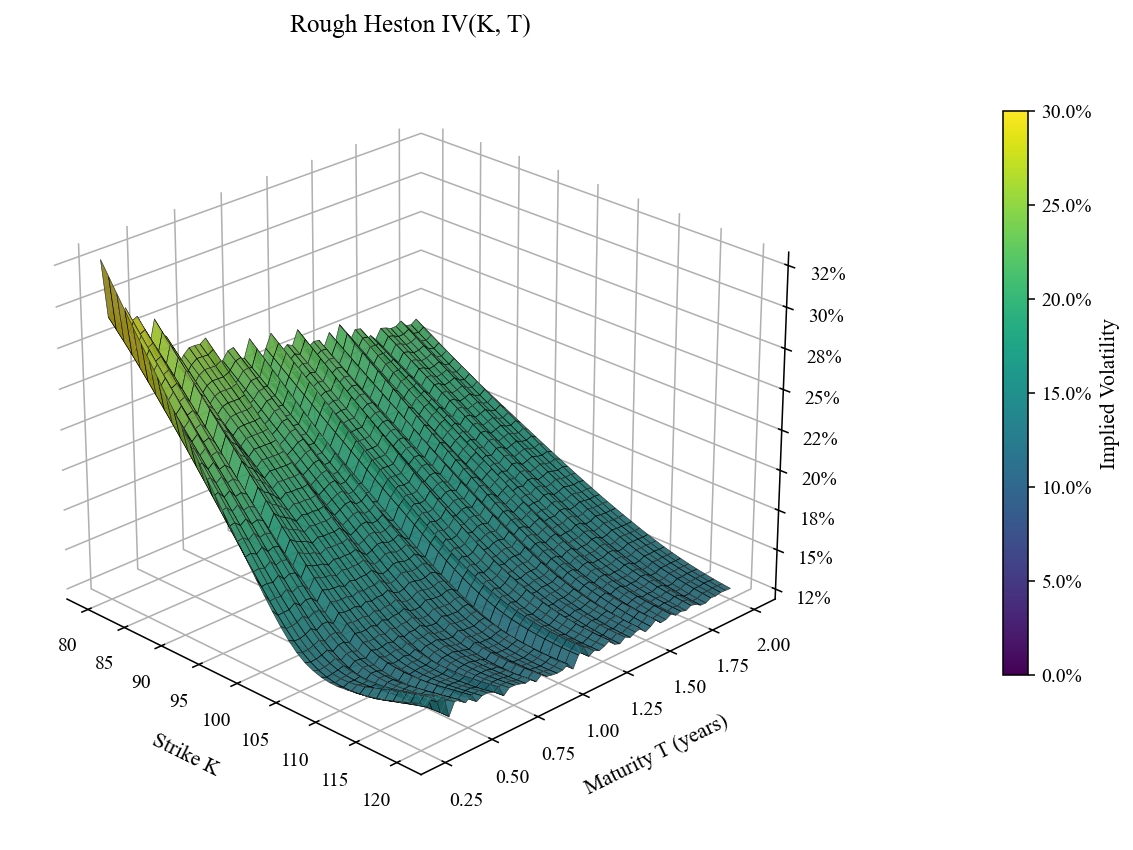

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D 


# ----------------------------
# Assumes S0, r, q, Ks, Ts, iv_rh are defined by here
# ----------------------------
q = 0.0 if 'q' not in globals() else q
Kg, Tg = np.meshgrid(Ks, Ts)
F_grid = S0 * np.exp((r - q) * Tg)
m_grid = np.log(Kg / F_grid) / np.sqrt(np.maximum(Tg, 1e-12))  # if you want moneyness later

# ----------------------------
# Styling
# ----------------------------
rcParams['font.family'] = 'Times New Roman'
fmt_pct = FuncFormatter(lambda x, pos: f"{100*x:.0f}%")

# Color scale (use fixed band or data-driven)
# vmin, vmax = float(np.nanmin(iv_rh)), float(np.nanmax(iv_rh))
vmin, vmax = 0.00, 0.30

norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("viridis")

# ----------------------------
# Figure and axes
# ----------------------------
fig = plt.figure(figsize=(9, 6.5))
ax = fig.add_subplot(111, projection="3d")
elev, azim = 25, -45

# ----------------------------
# Rough Heston IV(K, T)
# To plot vs moneyness instead of K, replace Kg with m_grid and update labels
# ----------------------------
surf = ax.plot_surface(
    Kg, Tg, iv_rh,
    facecolors=cmap(norm(iv_rh)),
    rstride=1, cstride=1,
    linewidth=0.3, edgecolor="black",
    antialiased=True, alpha=0.9
)
ax.plot_wireframe(
    Kg, Tg, iv_rh,
    rstride=2, cstride=2,
    color=(1, 1, 1, 0.18), linewidth=0.35
)
ax.view_init(elev=elev, azim=azim)
ax.set_title("Rough Heston IV(K, T)")
ax.set_xlabel("Strike K", labelpad=8)
ax.set_ylabel("Maturity T (years)", labelpad=8)
# ax.set_zlabel("Implied Volatility", labelpad=10)
ax.zaxis.set_major_formatter(fmt_pct)

# ----------------------------
# Colorbar
# ----------------------------
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
plt.tight_layout(rect=[0, 0, 0.92, 0.95])

cbar_ax = fig.add_axes([0.93, 0.20, 0.02, 0.62])
cbar_ax.set_facecolor('white')  
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.set_label("Implied Volatility")
cbar.formatter = FuncFormatter(lambda x, pos: f"{100*x:.1f}%")
cbar.update_ticks()

# ----------------------------
# Grid, panes, final tweaks
# ----------------------------
ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# fig.suptitle("IV Surface: Rough Heston (log-Euler)", fontsize=15, fontweight="bold", y=0.98)

# Optional: save
# plt.savefig("iv_surface_rough_heston_logeuler.png", dpi=150, bbox_inches="tight", facecolor="white")

plt.show()



C:\Users\datog\AppData\Local\Temp\ipykernel_11908\3868530129.py:116: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


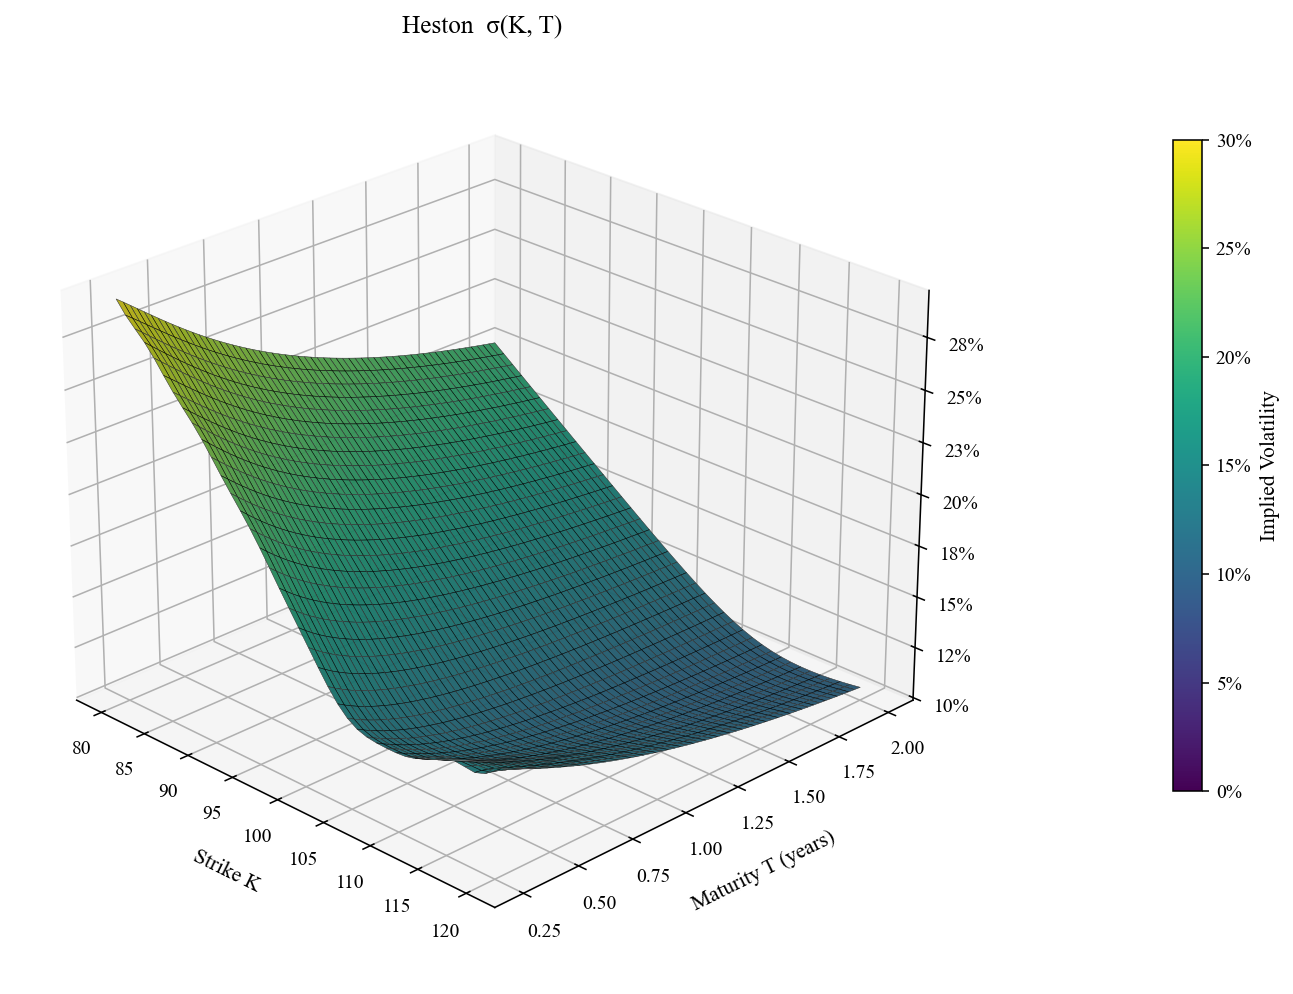

In [ ]:
# =========================
# Heston IV surface + 3D plot
# =========================
import numpy as np
import math
from scipy.integrate import quad   # needed by your heston_call
from scipy.special import ndtr     # vectorized Φ
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---- your pricing function (as provided) ----
def heston_call(S0, K, v0, r, t, kappa, theta, xi, rho):
    import numpy as np
    from scipy.integrate import quad
    def integrand(phi, Pnum):
        i = 1j
        u = 0.5 if Pnum == 1 else -0.5
        b = (kappa - rho * xi) if Pnum == 1 else kappa
        a = kappa * theta
        d = np.sqrt((rho * xi * phi * i - b)**2 - xi**2 * (2 * u * phi * i - phi**2))
        g = (b - rho * xi * phi * i + d) / (b - rho * xi * phi * i - d)
        exp1 = np.exp(i * phi * np.log(S0 / K))
        C = r * phi * i * t + a / xi**2 * ((b - rho * xi * phi * i + d) * t - 2 * np.log((1 - g * np.exp(d * t)) / (1 - g)))
        D = (b - rho * xi * phi * i + d) / xi**2 * ((1 - np.exp(d * t)) / (1 - g * np.exp(d * t)))
        f = exp1 * np.exp(C + D * v0)
        return np.real(f / (phi * i))
    P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0.0, 100.0, limit=250)[0]
    P2 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 2), 0.0, 100.0, limit=250)[0]
    return S0 * P1 - K * np.exp(-r * t) * P2

# ---- fast BS helpers + vectorized Newton IV (no loops over strikes) ----
def _bs_call_vec(F, K, df, T, sigma):
    volT = sigma * np.sqrt(T)
    inv  = 1.0 / np.maximum(volT, 1e-12)
    d1 = (np.log(F / K) + 0.5 * volT * volT) * inv
    d2 = d1 - volT
    return df * (F * ndtr(d1) - K * ndtr(d2))

def _vega_vec(F, K, df, T, sigma):
    volT = sigma * np.sqrt(T)
    inv  = 1.0 / np.maximum(volT, 1e-12)
    d1 = (np.log(F / K) + 0.5 * volT * volT) * inv
    return df * F * np.exp(-0.5 * d1 * d1) / math.sqrt(2.0*math.pi) * np.sqrt(T)

def implied_vol_newton_vec(target_C, S0, K, T, r, q, sigma0=None, iters=8, tol=1e-8):
    K  = np.asarray(K, float)
    F  = S0 * np.exp((r - q) * T)
    df = np.exp(-r * T)
    intrinsic = np.maximum(S0 * np.exp(-q*T) - K * df, 0.0)
    upper = S0 * np.exp(-q*T)
    C = np.clip(target_C, intrinsic, upper)
    if sigma0 is None:
        sigma0 = np.full_like(K, 0.2, dtype=float)
        atm = np.abs(np.log(F / K)) < 1e-4
        if np.any(atm):
            sigma0[atm] = np.clip((C[atm]/(df*F))*math.sqrt(2.0*math.pi)/np.sqrt(T), 1e-4, 3.0)
    sigma = np.clip(sigma0, 1e-6, 5.0)
    for _ in range(iters):
        price = _bs_call_vec(F, K, df, T, sigma)
        vega  = np.maximum(_vega_vec(F, K, df, T, sigma), 1e-12)
        step  = (price - C) / vega
        sigma = np.clip(sigma - step, 1e-6, 5.0)
        if np.nanmax(np.abs(step)) < tol:
            break
    return sigma

# =========================
# Config (edit to taste)
# =========================
# ---------- example usage ----------
Ks = np.linspace(80, 120, 40)
Ts = np.linspace(0.25, 2.00, 60)


# set your params here or reuse existing notebook vars
S0 = globals().get("S0", 100.0)
r  = globals().get("r", 0.0)
q  = globals().get("q", 0.0)
v0_rh    = globals().get("v0_rh", 0.04)
theta_rh = globals().get("theta_rh", 0.04)
kappa_rh = globals().get("kappa_rh", 0.5)
xi_rh    = globals().get("xi_rh", 0.8)
rho      = globals().get("rho", -0.7)
H        = globals().get("H", 0.1)
v0=v0_rh
kappa=kappa_rh
theta=theta_rh
xi=xi_rh
# =========================
# Build IV surface
# =========================
iv_heston = np.zeros((len(Ts), len(Ks)))
for i, T in enumerate(Ts):
    # price all strikes at this maturity (one quadrature per strike)
    prices = np.array([heston_call(S0, K, v0, r, T, kappa, theta, xi, rho) for K in Ks])
    # vectorized IV across strikes with a good warm start
    iv_heston[i, :] = implied_vol_newton_vec(prices, S0, Ks, T, r, q,
                                             sigma0=np.full_like(Ks, math.sqrt(theta)))

# =========================
# 3D plot (same style as your rough-Heston figure)
# =========================
Kg, Tg = np.meshgrid(Ks, Ts)
rcParams['font.family'] = 'Times New Roman'
fmt_pct = FuncFormatter(lambda x, pos: f"{100*x:.0f}%")

# contrast: auto band from data, or fix to [0, 30%]
# vmin = float(np.nanpercentile(iv_heston, 2))
# vmax = float(np.nanpercentile(iv_heston, 98))
vmin, vmax = 0.00, 0.30

norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("viridis")

fig = plt.figure(figsize=(10.5, 7.5), facecolor="white")
ax = fig.add_subplot(111, projection="3d")
ax.view_init(25, -45)

surf = ax.plot_surface(
    Kg, Tg, iv_heston,
    facecolors=cmap(norm(iv_heston)),
    rstride=1, cstride=1,
    linewidth=0.25, edgecolor="black",
    antialiased=True, alpha=0.95
)
ax.plot_wireframe(
    Kg, Tg, iv_heston,
    rstride=2, cstride=2,
    color=(1, 1, 1, 0.18), linewidth=0.35
)

ax.set_title("Heston  σ(K, T)")
ax.set_xlabel("Strike K", labelpad=8)
ax.set_ylabel("Maturity T (years)", labelpad=8)
ax.zaxis.set_major_formatter(fmt_pct)

# shared colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap); mappable.set_array([])
plt.tight_layout(rect=[0, 0, 0.92, 0.96])
cax = fig.add_axes([0.93, 0.20, 0.02, 0.62])
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("Implied Volatility")
cbar.formatter = fmt_pct
cbar.update_ticks()

# panes + grid
ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()


# Multi-Maturity Rough Heston Calibration Demo

This notebook uses local modules: `cal.py` for calibration and `rough.py` for Monte Carlo.

Market option smiles are fetched via `yfinance` for multiple expiries.


In [1]:
import os, sys, math, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

HERE = os.path.abspath(os.getcwd())
if HERE not in sys.path:
    sys.path.insert(0, HERE)

from calibration import calibrate_rough_heston, calibrate_heston, heston_smile_prices, _implied_vol, _implied_vol_call
from rough import rough_heston_terminal_parallel_pool
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 11

def prices_to_ivs(S, r, q, T, strikes, prices, option_type='call'):
    ivs = []
    for K, p in zip(np.asarray(strikes, float), np.asarray(prices, float)):
        try:
            ivs.append(_implied_vol(S, float(K), float(T), float(r), float(q), float(p), option_type))
        except Exception:
            ivs.append(np.nan)
    return np.array(ivs, float)

def rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    m = np.isfinite(a) & np.isfinite(b)
    if not np.any(m):
        return np.nan
    d = a[m] - b[m]
    return float(np.sqrt(np.mean(d*d)))


## Build Smiles from Market

6 [('CALL', '2025-12-05'), ('PUT', '2025-12-05'), ('CALL', '2026-04-30'), ('PUT', '2026-04-30'), ('CALL', '2026-09-30'), ('PUT', '2026-09-30')]


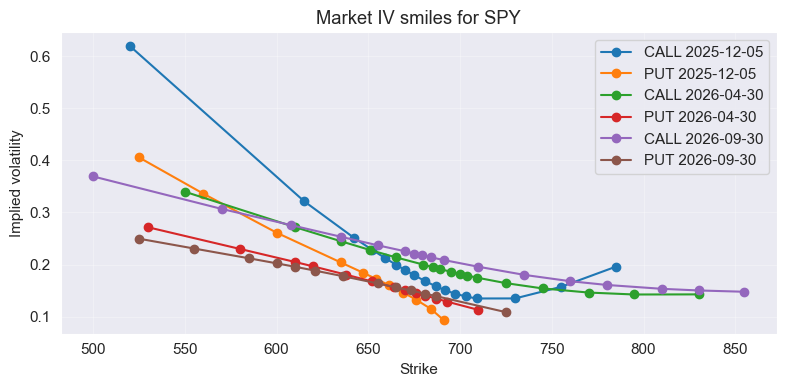

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

TICKER = 'SPY'

TARGET_DAYS = [30,  180, 365]
R = 0.00
Q = 0.00

MONEYNESS_CALL = (0.72, 1.28)
MONEYNESS_PUT = (0.78, 1.18)
MIN_POINTS = 6
MAX_AGE_DAYS = 3
MAX_STRIKES_CALL = 17
MAX_STRIKES_PUT = 13


def _prep_chain(df):
    df = df.copy()
    keep = np.ones(len(df), dtype=bool)
    if 'lastPrice' in df:
        keep &= pd.to_numeric(df['lastPrice'], errors='coerce').fillna(0) > 0
    if 'openInterest' in df:
        keep &= pd.to_numeric(df['openInterest'], errors='coerce').fillna(0) >= 0
    if 'volume' in df:
        keep &= pd.to_numeric(df['volume'], errors='coerce').fillna(0) >= 0
    df = df[keep]
    if 'lastTradeDate' in df:
        ltd = pd.to_datetime(df['lastTradeDate'], errors='coerce')
        if isinstance(ltd, pd.Series):
            try:
                ltd = ltd.dt.tz_convert(None)
            except TypeError:
                ltd = ltd.dt.tz_localize(None)
        cut = pd.Timestamp.utcnow().normalize() - pd.Timedelta(days=MAX_AGE_DAYS)
        if cut.tzinfo is not None:
            cut = cut.tz_convert(None)
        df = df[(ltd >= cut) | ltd.isna()]
        df['lastTradeDate'] = ltd
    return df


def _mid_from_chain(df):
    bid = pd.to_numeric(df.get('bid'), errors='coerce')
    ask = pd.to_numeric(df.get('ask'), errors='coerce')
    last = pd.to_numeric(df.get('lastPrice'), errors='coerce')
    mid = 0.5 * (bid + ask)
    fill = (~np.isfinite(mid)) | (mid <= 0)
    if last is not None:
        in_spread = (
            np.isfinite(last) & np.isfinite(bid) & np.isfinite(ask)
            & (last >= (bid - 1e-8)) & (last <= (ask + 1e-8))
        )
        mid[fill & in_spread] = last[fill & in_spread]
    mid[~np.isfinite(mid)] = last[~np.isfinite(mid)]
    return np.asarray(mid, float)


def _downsample_sorted(strikes, mids, target):
    n = strikes.size
    if n <= target:
        return strikes, mids
    idx = np.linspace(0, n - 1, target).round().astype(int)
    return strikes[idx], mids[idx]


def _smile_from_chain(df, option_type, S0, r, q, expiry,
                      moneyness, max_points):
    df = _prep_chain(df)
    strikes_raw = pd.to_numeric(df.get('strike'), errors='coerce').to_numpy()
    mids_raw = _mid_from_chain(df)
    mask = np.isfinite(strikes_raw) & np.isfinite(mids_raw) & (mids_raw > 0)
    strikes = strikes_raw[mask]
    mids = mids_raw[mask]
    if strikes.size < MIN_POINTS:
        return None

    lo, hi = moneyness
    mk = strikes / float(S0)
    mask2 = (mk >= lo) & (mk <= hi)
    if np.count_nonzero(mask2) < MIN_POINTS:
        lo *= 0.95
        hi *= 1.05
        mask2 = (mk >= lo) & (mk <= hi)
    strikes = strikes[mask2]
    mids = mids[mask2]
    if strikes.size < MIN_POINTS:
        return None

    order = np.argsort(strikes)
    strikes = strikes[order]
    mids = mids[order]
    strikes, mids = _downsample_sorted(strikes, mids, max_points)

    try:
        exp_dt = pd.to_datetime(expiry)
        if exp_dt.tzinfo is not None:
            exp_dt = exp_dt.tz_convert(None)
        exp_date = exp_dt.date()
        today = pd.Timestamp.today().date()
        T = max((exp_date - today).days, 1) / 365.0
    except Exception:
        raise RuntimeError(f'Could not parse expiry {expiry}')

    return dict(
        S0=float(S0),
        r=float(r),
        q=float(q),
        T=float(T),
        strikes=np.asarray(strikes, float),
        mids=np.asarray(mids, float),
        cp=str(option_type).lower(),
        expiry=str(expiry),
    )


def build_smiles_from_ticker(ticker, target_days, r, q):
    tk = yf.Ticker(ticker)
    avail = tk.options
    if not avail:
        raise RuntimeError('No option expiries available from yfinance.')

    def closest(days):
        today = pd.Timestamp.today().date()
        tgt = today + pd.Timedelta(days=int(days))
        return min(avail, key=lambda s: abs(pd.to_datetime(s).date() - tgt))

    expiries = []
    seen = set()
    for d in target_days:
        e = closest(d)
        if e not in seen:
            expiries.append(e)
            seen.add(e)

    hist = tk.history(period='1d')
    if getattr(hist, 'empty', False):
        raise RuntimeError(f'No spot history for {ticker}.')
    S0 = float(hist['Close'].iloc[-1])

    smiles = []
    for e in expiries:
        chain = tk.option_chain(e)
        entries = (
            ('call', MONEYNESS_CALL, MAX_STRIKES_CALL, chain.calls),
            ('put', MONEYNESS_PUT, MAX_STRIKES_PUT, chain.puts),
        )
        for opt_type, money, max_pts, df in entries:
            sm = _smile_from_chain(df, opt_type, S0, r, q, e, money, max_pts)
            if sm is not None:
                smiles.append(sm)
    return smiles


def plot_smiles_iv(smiles, ticker=None):
    fig, ax = plt.subplots(figsize=(8, 4))
    for sm in smiles:
        ivs = [_implied_vol(sm['S0'], K, sm['T'], sm['r'], sm['q'], price, sm['cp'])
               for K, price in zip(sm['strikes'], sm['mids'])]
        ivs = np.array(ivs, float)
        mask = np.isfinite(ivs)
        label = f"{sm['cp'].upper()} {sm['expiry']}"
        ax.plot(sm['strikes'][mask], ivs[mask], marker='o', linestyle='-', label=label)
    ax.set_xlabel('Strike')
    ax.set_ylabel('Implied volatility')
    ax.set_title(f'Market IV smiles for {ticker}' if ticker else 'Market IV smiles')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()

smiles = build_smiles_from_ticker(TICKER, TARGET_DAYS, R, Q)
print(len(smiles), [(sm['cp'].upper(), sm['expiry']) for sm in smiles])
plot_smiles_iv(smiles, ticker=TICKER)
plt.show()


## Joint Calibration (IV-space)

In [4]:
RH_BOUNDS = ((0.005,0.25),(0.2,4.0),(0.005,0.25),(0.1,1.5),(-0.999,-0.01),(0.05,0.35))
rh_cfg = dict(N=256, N_per_year=480, N_min=128, paths=5000, batch_size=2048, n_workers=8, use_numba=True)
rh_x0 = (0.06, 1.2, 0.06, 0.6, -0.2, 0.2)
smiles_list = [(s['S0'], s['r'], s['q'], s['T'], s['strikes'], s['mids'], s['cp']) for s in smiles]
best_rh, rh_raw = calibrate_rough_heston(smiles_list, metric='iv', vega_weight=True, x0=rh_x0, mc=rh_cfg, seed=1234, bounds=RH_BOUNDS, multistart=3, options={'maxiter': 120, 'finite_diff_rel_step': 5e-2}, verbose=True, parallel_backend='thread')
best_rh


[RoughHeston #1 start #1] iter=0
[RoughHeston #1] iter=1  f=0.391580  df=nan  |dx|=nan  15.99s
[RoughHeston #1] iter=2  f=0.391578  df=-1.67e-06  |dx|=1.99e-07  7.92s
[RoughHeston #1] iter=3  f=0.391575  df=-3.96e-06  |dx|=2.83e-06  4.38s
[RoughHeston #1] iter=4  f=0.391558  df=-1.66e-05  |dx|=2.37e-06  4.41s
[RoughHeston #1] iter=5  f=0.155563  df=-2.36e-01  |dx|=4.98e-02  37.53s
[RoughHeston #1] iter=6  f=0.153395  df=-2.17e-03  |dx|=4.28e-03  13.98s
[RoughHeston #1] iter=7  f=0.153395  df=-4.32e-08  |dx|=2.08e-07  27.04s
[RoughHeston #1] iter=8  f=0.153395  df=-6.46e-07  |dx|=1.18e-05  4.42s
[RoughHeston #1] iter=9  f=0.153391  df=-3.34e-06  |dx|=1.51e-05  12.98s
[RoughHeston #1] iter=10  f=0.153391  df=-1.58e-07  |dx|=9.55e-07  12.98s
[RoughHeston #1] iter=11  f=0.153391  df=-1.81e-08  |dx|=8.31e-06  4.38s
[RoughHeston #1] iter=12  f=0.153390  df=-9.57e-07  |dx|=7.63e-06  4.38s
[RoughHeston #1] iter=13  f=0.153390  df=-5.97e-07  |dx|=5.47e-06  8.78s
[RoughHeston #1] iter=14  f=0.15

{'v0': np.float64(0.031209097774678497),
 'kappa': np.float64(1.2836130684541673),
 'theta': np.float64(0.07540723868895423),
 'eta': np.float64(0.5618674442774685),
 'rho': np.float64(-0.6515691818859309),
 'H': np.float64(0.21341581107829272),
 'obj': 0.12424069393126161,
 'success': False,
 'nit': 26,
 'history': [{'iter': 1,
   'f': 0.3915801556155423,
   'df': nan,
   'dx': nan,
   't': 15.989254474639893,
   'dt': 15.989254474639893,
   'x': array([ 0.0599998 ,  1.19999999,  0.0599998 ,  0.60000322, -0.20000054,
           0.20000055])},
  {'iter': 2,
   'f': 0.39157848734302064,
   'df': -1.6682725216821126e-06,
   'dx': 1.989119025121694e-07,
   't': 23.908730030059814,
   'dt': 7.919475555419922,
   'x': array([ 0.05999965,  1.19999999,  0.0599998 ,  0.6000031 , -0.20000052,
           0.20000054])},
  {'iter': 3,
   'f': 0.3915745276065871,
   'df': -3.959736433523098e-06,
   'dx': 2.8336870906467707e-06,
   't': 28.291374444961548,
   'dt': 4.382644414901733,
   'x': array([

In [9]:
x0_ref = tuple(best_rh[k] for k in ['v0','kappa','theta','eta','rho','H'])
RH_BOUNDS = ((0.005,0.25),(0.2,4.0),(0.005,0.25),(0.1,1.5),(-0.999,-0.01),(0.05,0.35))
rh_cfg = dict(N=256, N_per_year=480, N_min=256, paths=15000, batch_size=4096, n_workers=12, use_numba=True)
smiles_list = [(s['S0'], s['r'], s['q'], s['T'], s['strikes'], s['mids'], s['cp']) for s in smiles]
best_rh, rh_raw = calibrate_rough_heston(smiles_list, metric='iv', vega_weight=True, x0=x0_ref, mc=rh_cfg, seed=1234, bounds=RH_BOUNDS, multistart=3, options={'maxiter': 120, 'finite_diff_rel_step': 5e-2}, verbose=True, parallel_backend='thread')
best_rh

[RoughHeston #1 start #1] iter=0
[RoughHeston #1] iter=1  f=0.119884  df=nan  |dx|=nan  205.47s
[RoughHeston #1] iter=2  f=0.119884  df=-2.76e-07  |dx|=7.63e-09  74.76s
[RoughHeston #1] iter=3  f=0.119884  df=+2.17e-13  |dx|=1.31e-14  206.12s
[RoughHeston #1 best] f=0.119884  iters=3  486.35s
[RoughHeston #2 start #2] iter=0
[RoughHeston #2 best] f=0.115640  iters=0  310.33s
[RoughHeston #3 start #3] iter=0
[RoughHeston #3] iter=1  f=0.123985  df=nan  |dx|=nan  102.94s
[RoughHeston #3] iter=2  f=0.123918  df=-6.70e-05  |dx|=4.39e-04  29.37s
[RoughHeston #3] iter=3  f=0.123916  df=-1.52e-06  |dx|=3.13e-06  103.49s
[RoughHeston #3] iter=4  f=0.123916  df=-2.87e-07  |dx|=9.57e-07  29.43s
[RoughHeston #3] iter=5  f=0.123914  df=-1.39e-06  |dx|=1.02e-05  14.77s
[RoughHeston #3] iter=6  f=0.123911  df=-3.13e-06  |dx|=1.14e-04  29.41s
[RoughHeston #3] iter=7  f=0.123829  df=-8.19e-05  |dx|=7.43e-04  44.26s
[RoughHeston #3] iter=8  f=0.123747  df=-8.29e-05  |dx|=6.90e-04  73.49s
[RoughHeston #

{'v0': np.float64(0.03230660525846057),
 'kappa': np.float64(1.2102733740052225),
 'theta': np.float64(0.07253349945115428),
 'eta': np.float64(0.5955194943659934),
 'rho': np.float64(-0.6677216502826859),
 'H': np.float64(0.20578047234629107),
 'obj': 0.11563946799270064,
 'success': False,
 'nit': 0,
 'history': []}

## Classic Heston Calibration


In [10]:
HESTON_BOUNDS = ((1e-4,0.5),(0.05,8.0),(1e-4,0.5),(0.02,2.5),(-0.999,-0.01))
heston_cfg = dict(integration_limit=160.0)
heston_x0 = (0.06, 1.2, 0.06, 0.6, -0.2)

best_heston, heston_raw = calibrate_heston(
    smiles_list,
    metric='iv',
    vega_weight=True,
    x0=heston_x0,
    mc=heston_cfg,
    bounds=HESTON_BOUNDS,
    multistart=3,
    options={'maxiter': 200, 'ftol': 1e-8, 'gtol': 1e-6},
    verbose=True
)
best_heston



[Heston #1 start #1] iter=0
[Heston #1] iter=1  f=0.214010  df=nan  |dx|=nan  8.35s
[Heston #1] iter=2  f=0.203550  df=-1.05e-02  |dx|=1.94e-02  1.47s
[Heston #1] iter=3  f=0.199549  df=-4.00e-03  |dx|=5.85e-03  1.45s
[Heston #1] iter=4  f=0.179368  df=-2.02e-02  |dx|=2.47e-02  1.43s
[Heston #1] iter=5  f=0.171190  df=-8.18e-03  |dx|=5.73e-02  1.39s
[Heston #1] iter=6  f=0.147167  df=-2.40e-02  |dx|=2.34e-01  1.62s
[Heston #1] iter=7  f=0.119335  df=-2.78e-02  |dx|=4.27e-01  8.93s
[Heston #1] iter=8  f=0.109776  df=-9.56e-03  |dx|=1.83e-01  1.92s
[Heston #1] iter=9  f=0.108646  df=-1.13e-03  |dx|=4.84e-02  1.97s
[Heston #1] iter=10  f=0.108174  df=-4.71e-04  |dx|=3.04e-02  1.96s
[Heston #1] iter=11  f=0.108123  df=-5.16e-05  |dx|=1.02e-02  1.93s
[Heston #1] iter=12  f=0.108128  df=+5.54e-06  |dx|=2.60e-03  1.95s
[Heston #1] iter=13  f=0.108129  df=+1.13e-06  |dx|=1.26e-03  1.94s
[Heston #1] iter=14  f=0.108128  df=-1.10e-06  |dx|=1.93e-03  1.96s
[Heston #1] iter=15  f=0.108122  df=-6.1

{'v0': np.float64(0.04277027664988387),
 'kappa': np.float64(0.9247479707732779),
 'theta': np.float64(0.2219021151338011),
 'sigma': np.float64(2.261262093365661),
 'rho': np.float64(-0.6586355480964137),
 'obj': 0.10503550889991725,
 'success': True,
 'nit': 23,
 'history': [{'iter': 1,
   'f': 0.23188712909102605,
   'df': nan,
   'dx': nan,
   't': 6.631808519363403,
   'dt': 6.631808519363403,
   'x': array([ 0.04677928,  1.13763264,  0.04364767,  0.61481736, -0.23475998])},
  {'iter': 2,
   'f': 0.20994865079956002,
   'df': -0.02193847829146603,
   'dx': 0.041483404884365145,
   't': 7.978434801101685,
   'dt': 1.3466262817382812,
   'x': array([ 0.0385144 ,  1.13508171,  0.0403964 ,  0.65129456, -0.25222139])},
  {'iter': 3,
   'f': 0.20541734670507963,
   'df': -0.004531304094480382,
   'dx': 0.011579775373131894,
   't': 9.402382135391235,
   'dt': 1.4239473342895508,
   'x': array([ 0.03946697,  1.13580483,  0.04330193,  0.64117088, -0.24755986])},
  {'iter': 4,
   'f': 0.19

## Compare Rough and Classic Heston


Overall mean RMSE (Rough Heston): price= 4.649713151065073  iv= 0.038755907584293085
Overall mean RMSE (Heston): price= 4.792555128555855  iv= 0.036703574814299936


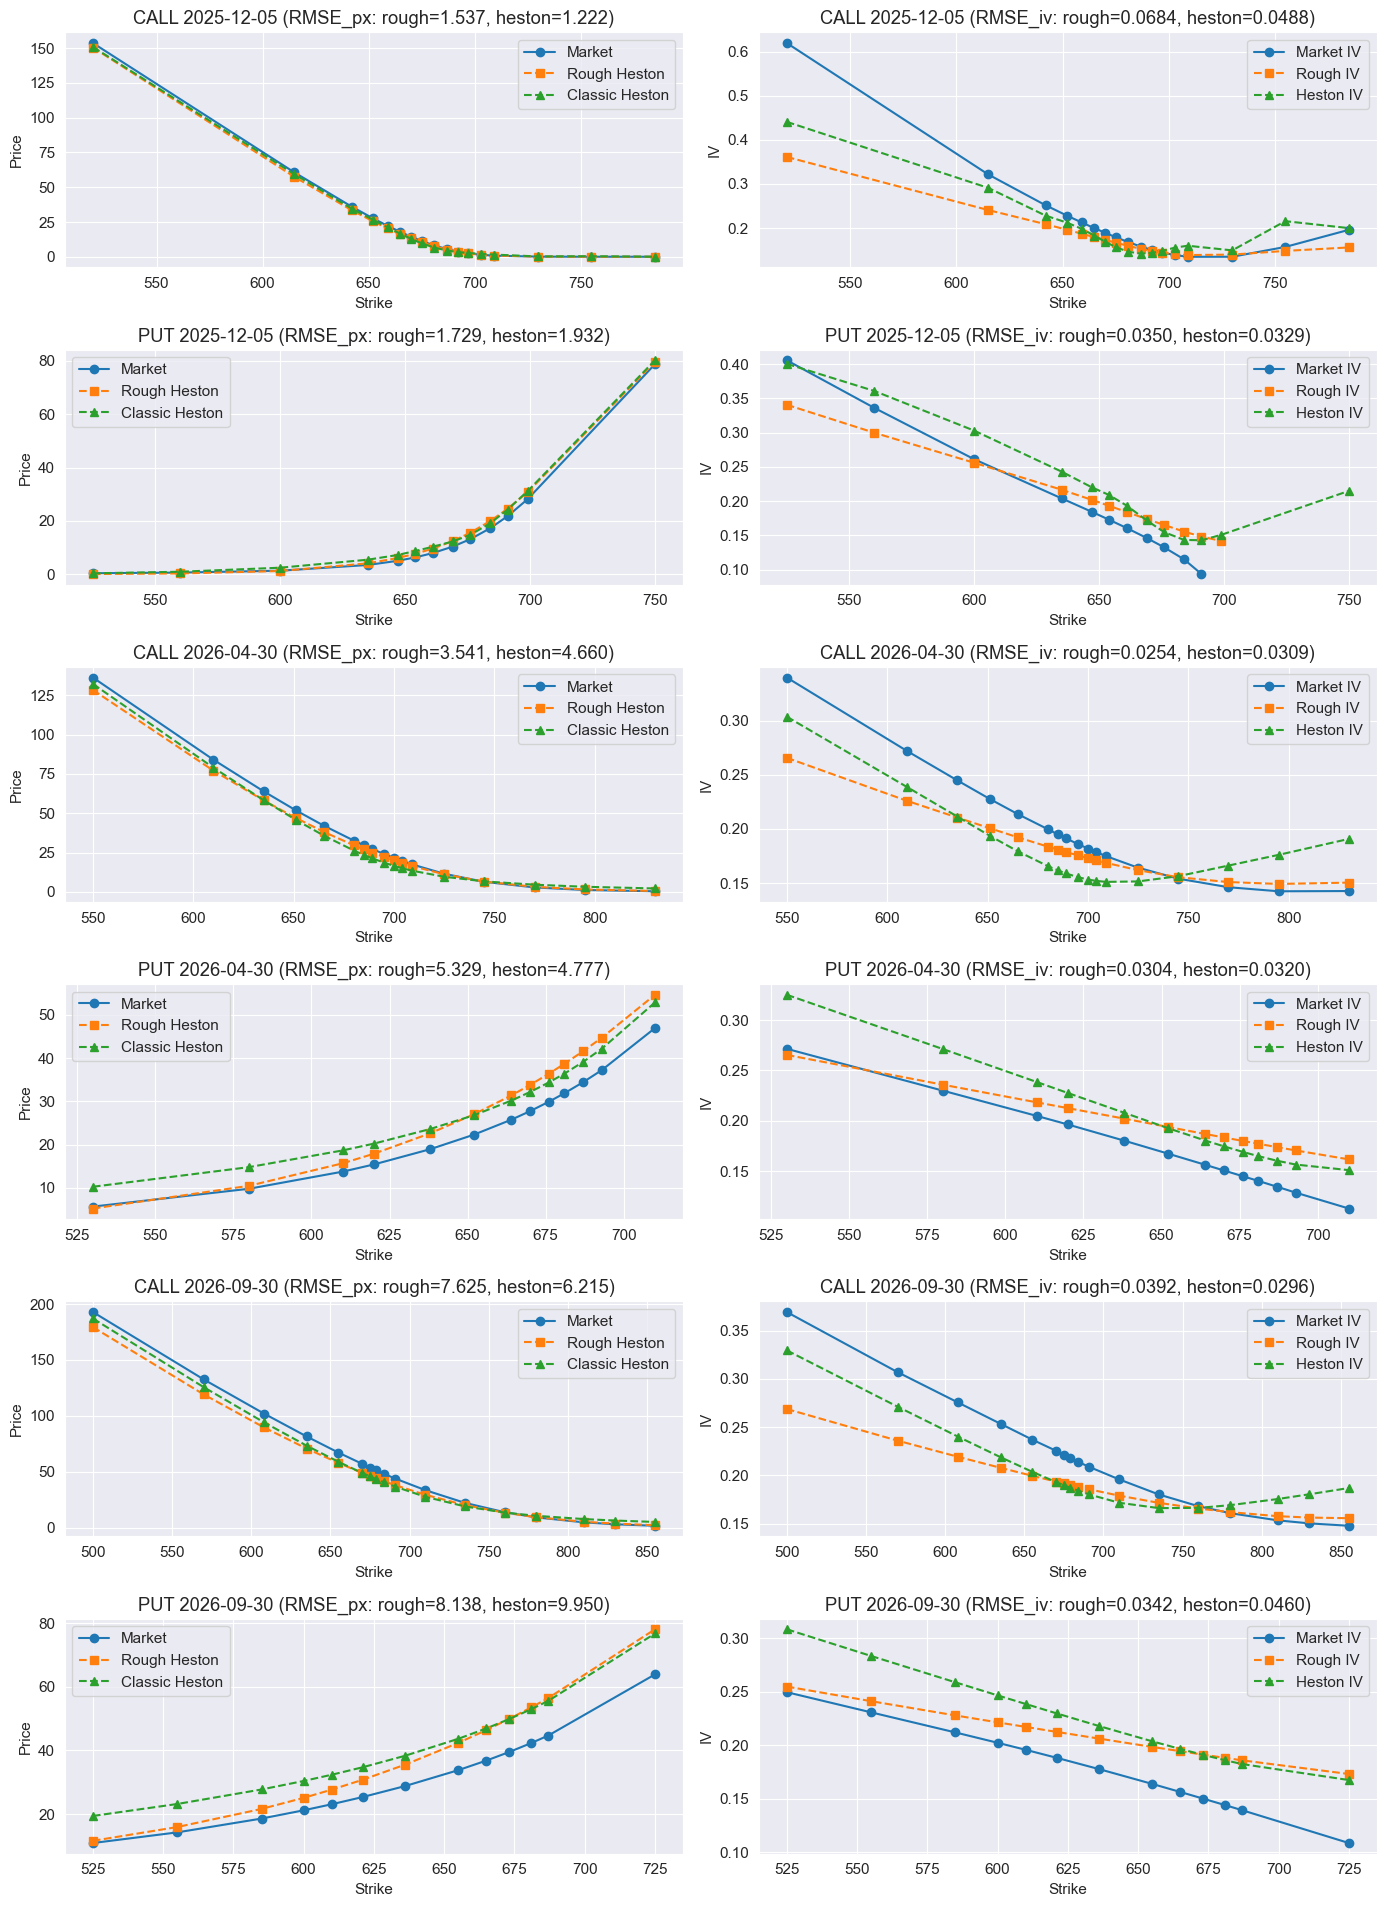

In [14]:
def evaluate_rough(params, smiles, mc, backend='thread'):
    v0=params['v0']; kappa=params['kappa']; theta=params['theta']
    eta=params['eta']; rho=params['rho']; H=params['H']
    results=[]
    Exec = ThreadPoolExecutor if str(backend).lower().startswith('thread') else ProcessPoolExecutor
    for sm in smiles:
        S0, r, q, T = sm['S0'], sm['r'], sm['q'], sm['T']
        strikes = sm['strikes']
        cp = sm['cp']
        N_eff = int(mc.get('N', 192))
        Npy = mc.get('N_per_year', None)
        if Npy is not None:
            try:
                N_eff = max(int(mc.get('N_min',128)), int(math.ceil(float(Npy)*float(T))))
            except Exception:
                N_eff = int(mc.get('N', 192))
        with Exec(max_workers=int(mc.get('n_workers',4))) as ex:
            ST = rough_heston_terminal_parallel_pool(
                ex, S0=S0, v0=v0, T=T, N=N_eff, n_paths=int(mc.get('paths',12000)),
                H=H, kappa=kappa, theta=theta, eta=eta, rho=rho, r=r, q=q,
                base_seed=9091+int(1000*T), batch_size=int(mc.get('batch_size',4096)),
                use_numba=mc.get('use_numba',None)
            )
        DF = math.exp(-r*T)
        if cp == 'put':
            payoff = np.maximum(strikes[None,:] - ST[:,None], 0.0)
        else:
            payoff = np.maximum(ST[:,None] - strikes[None,:], 0.0)
        model_px = DF * payoff.mean(axis=0)
        mkt_iv = prices_to_ivs(S0, r, q, T, strikes, sm['mids'], cp)
        mod_iv = prices_to_ivs(S0, r, q, T, strikes, model_px, cp)
        results.append(dict(expiry=sm.get('expiry'), T=T, cp=cp, strikes=strikes, mids=sm['mids'],
                             model_px=model_px, mkt_iv=mkt_iv, mod_iv=mod_iv,
                             rmse_px=rmse(model_px, sm['mids']), rmse_iv=rmse(mod_iv, mkt_iv)))
    return results

rough_evals = evaluate_rough(best_rh, smiles, rh_cfg, backend='thread')
print('Overall mean RMSE (Rough Heston): price=', float(np.nanmean([e['rmse_px'] for e in rough_evals])),
      ' iv=', float(np.nanmean([e['rmse_iv'] for e in rough_evals])))



def evaluate_heston(params, smiles, cfg):
    limit = float(cfg.get('integration_limit', 100.0))
    out = []
    for sm in smiles:
        S0, r, q, T = sm['S0'], sm['r'], sm['q'], sm['T']
        strikes = sm['strikes']
        cp = sm['cp']
        model_px = heston_smile_prices(
            S0, r, q, T, strikes,
            v0=params['v0'], kappa=params['kappa'], theta=params['theta'],
            sigma=params['sigma'], rho=params['rho'],
            option=cp, integration_limit=limit,
        )
        mkt_iv = prices_to_ivs(S0, r, q, T, strikes, sm['mids'], cp)
        mod_iv = prices_to_ivs(S0, r, q, T, strikes, model_px, cp)
        out.append(dict(expiry=sm.get('expiry'), T=T, cp=cp, strikes=strikes, mids=sm['mids'],
                        model_px=model_px, mkt_iv=mkt_iv, mod_iv=mod_iv,
                        rmse_px=rmse(model_px, sm['mids']), rmse_iv=rmse(mod_iv, mkt_iv)))
    return out

heston_evals = evaluate_heston(best_heston, smiles, heston_cfg)
print('Overall mean RMSE (Heston): price=', float(np.nanmean([e['rmse_px'] for e in heston_evals])),
      ' iv=', float(np.nanmean([e['rmse_iv'] for e in heston_evals])))

n = len(smiles)
fig, axs = plt.subplots(n, 2, figsize=(14, 3.2*n), sharex=False)
if n == 1:
    axs = np.array([axs])
for idx, (sm, er, eh) in enumerate(zip(smiles, rough_evals, heston_evals)):
    label = '{} {}'.format(sm['cp'].upper(), sm.get('expiry') or 'T={:.3f}y'.format(sm['T']))
    ax = axs[idx, 0]
    ax.plot(sm['strikes'], sm['mids'], 'o-', label='Market')
    ax.plot(sm['strikes'], er['model_px'], 's--', label='Rough Heston')
    ax.plot(sm['strikes'], eh['model_px'], '^--', label='Classic Heston')
    ax.set_title('{} (RMSE_px: rough={:.3f}, heston={:.3f})'.format(label, er['rmse_px'], eh['rmse_px']))
    ax.set_xlabel('Strike'); ax.set_ylabel('Price'); ax.legend()
    ax = axs[idx, 1]
    ax.plot(sm['strikes'], er['mkt_iv'], 'o-', label='Market IV')
    ax.plot(sm['strikes'], er['mod_iv'], 's--', label='Rough IV')
    ax.plot(sm['strikes'], eh['mod_iv'], '^--', label='Heston IV')
    ax.set_title('{} (RMSE_iv: rough={:.4f}, heston={:.4f})'.format(label, er['rmse_iv'], eh['rmse_iv']))
    ax.set_xlabel('Strike'); ax.set_ylabel('IV'); ax.legend()
plt.tight_layout(); plt.show()

